# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout,SimpleRNN,Input,GRU,Flatten
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Data File

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Software_Architecture /Creating Feature Using DeepLearning/features_lstm.csv")
data = data.iloc[:,1:]

# Renaming column 'severity'

In [5]:
data = data.rename(columns={'sevrity': 'severity'})
data.head()

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,severity,smell,id
0,-0.095091,0.094136,-0.155968,-0.277106,-0.096803,0.151674,-0.076158,0.007527,0.216296,-0.106366,...,-0.013313,-0.204653,0.108312,0.039484,-0.161035,0.042890,0.259271,1,god-class,910
1,-0.113796,0.084324,-0.114097,-0.224774,-0.227246,0.118165,-0.112589,0.004592,0.195760,-0.056564,...,-0.079901,-0.140628,0.091175,0.133248,-0.144530,-0.071371,0.341742,3,data-class,214
2,-0.073298,0.098071,-0.228914,-0.185084,-0.119284,0.118947,-0.159412,-0.061848,0.141519,-0.068608,...,-0.052565,-0.090053,0.098385,0.226798,-0.099325,0.126005,0.247462,4,god-class,1113
3,-0.111986,0.090784,-0.107854,-0.236817,-0.109894,0.079085,-0.100038,0.057145,0.257870,-0.095232,...,-0.072912,-0.199042,0.169178,0.052286,-0.144915,-0.154389,0.377775,3,data-class,375
4,-0.079752,0.067778,-0.251782,-0.049088,-0.117858,0.122254,-0.108178,-0.040676,0.266969,-0.079081,...,-0.024582,-0.099144,0.131354,0.100696,-0.107236,-0.062185,0.251987,2,feature-envy,1399


In [6]:
smells =data['smell'].unique()

In [7]:
for i in smells:
  print(i,len(data[data['smell'] == i]))

god-class 403
data-class 404
feature-envy 285
long-method 287


In [8]:
rndperm = np.random.permutation(data.shape[0])

data = data.iloc[rndperm[:],:].copy()

In [9]:
data.shape


(1379, 515)

In [10]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,severity,smell,id
62,-0.072539,0.078277,-0.091376,-0.267038,-0.068147,0.050010,-0.071691,0.053168,0.266041,-0.092950,...,-0.091774,-0.152297,0.182138,0.044439,-0.131422,-0.139427,0.400041,3,data-class,373
1305,-0.239326,0.063073,-0.267407,-0.187388,-0.057296,0.131539,-0.096149,-0.037748,0.088972,-0.084508,...,-0.013848,-0.081615,0.037644,0.171746,-0.057007,0.025125,0.260283,3,long-method,737
550,-0.119613,0.088592,-0.056058,-0.248236,-0.085582,0.184177,-0.027156,0.039953,0.075869,-0.142960,...,-0.050474,-0.300238,0.090843,0.038415,-0.102767,-0.017243,0.277492,1,feature-envy,1241
595,-0.171824,0.065988,-0.179036,-0.208816,-0.130502,0.116881,-0.092753,0.005761,0.194564,-0.071078,...,-0.114713,-0.149146,0.131189,0.091931,-0.124910,-0.047583,0.356176,3,god-class,1112
940,-0.113118,0.081018,-0.101243,-0.333754,-0.235130,0.155661,-0.109720,-0.005702,0.299687,-0.046272,...,-0.019727,-0.175903,0.067993,0.078766,-0.110363,-0.064192,0.276570,1,god-class,864


In [11]:
y = data[['smell']]
X = data.drop(columns =['smell','severity','id'])

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

In [13]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
y_test= enc.fit_transform(y_test[['smell']]).toarray()
y_train=enc.transform(y_train[['smell']]).toarray()

In [14]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train.shape

(1103, 512, 1)

In [15]:
model = Sequential()
model.add(GRU(512, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(GRU(256,return_sequences=True))
model.add(GRU(128,return_sequences=True))
model.add(GRU(64,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(16,return_sequences=True))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
plot_model(model, 'gruMulticlass.png', show_shapes=True)

#callbacks: checkpoint, csv_logger
filepath="gruMulticlass.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
csv_log=CSVLogger('gruMulticlass_log.csv',separator=',',append=False)
callbacks_list=[checkpoint,csv_log]
history=model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test,y_test), callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 512, 512)          791040    
                                                                 
 gru_1 (GRU)                 (None, 512, 256)          591360    
                                                                 
 gru_2 (GRU)                 (None, 512, 128)          148224    
                                                                 
 gru_3 (GRU)                 (None, 512, 64)           37248     
                                                                 
 gru_4 (GRU)                 (None, 512, 32)           9408      
                                                                 
 gru_5 (GRU)                 (None, 512, 16)           2400      
                                                                 
 flatten (Flatten)           (None, 8192)              0

Text(0, 0.5, 'accuracy')

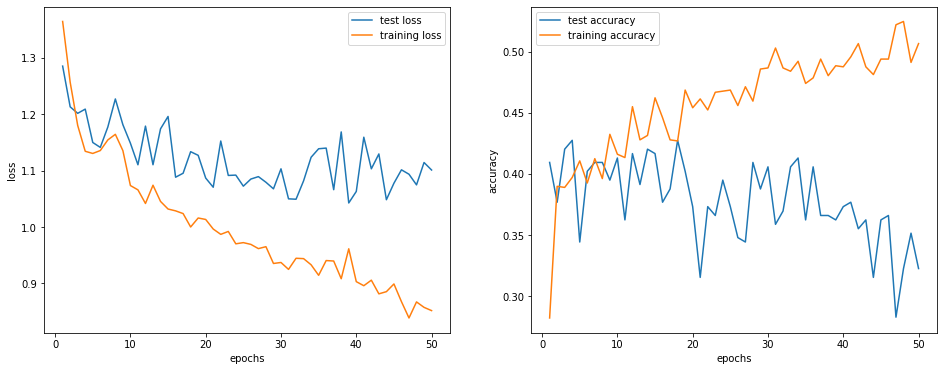

In [17]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1),history.history['val_loss'], label='test loss')
plt.plot(np.arange(1,51,1),history.history['loss'], label='training loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1),history.history['val_accuracy'], label='test accuracy')
plt.plot(np.arange(1,51,1),history.history['accuracy'], label='training accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [18]:
model2 = Sequential()
model2.add(LSTM(512, input_shape=(X_train.shape[1], 1), return_sequences=True))
model2.add(LSTM(256,return_sequences=True))
model2.add(LSTM(128,return_sequences=True))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

In [19]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())
plot_model(model2, 'LSTMMulticlass.png', show_shapes=True)

#callbacks: checkpoint, csv_logger
filepath="LSTMMulticlass.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
csv_log=CSVLogger('LSTMMulticlass_log.csv',separator=',',append=False)
callbacks_list=[checkpoint,csv_log]
history=model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test,y_test), callbacks=callbacks_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512, 256)          787456    
                                                                 
 lstm_2 (LSTM)               (None, 512, 128)          197120    
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 262148    
                                                                 
Total params: 2,299,396
Trainable params: 2,299,396
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
18/18 [=====================

Text(0, 0.5, 'accuracy')

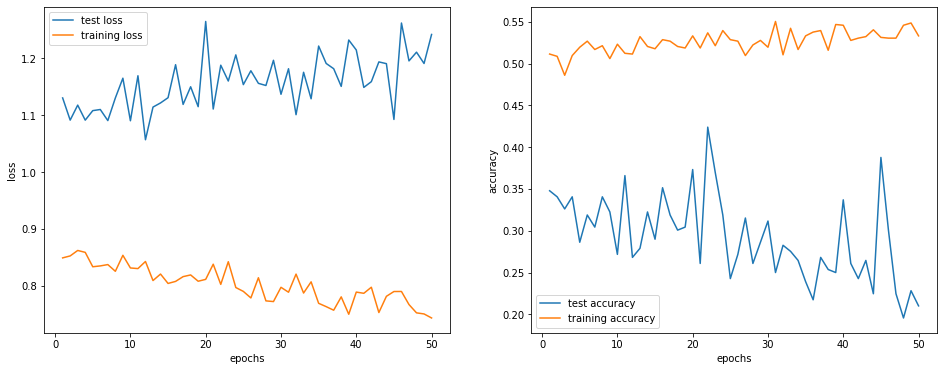

In [20]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(np.arange(1,51,1),history.history['val_loss'], label='test loss')
plt.plot(np.arange(1,51,1),history.history['loss'], label='training loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(np.arange(1,51,1),history.history['val_accuracy'], label='test accuracy')
plt.plot(np.arange(1,51,1),history.history['accuracy'], label='training accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')